# 2. Tree cover widget

The default view for the tree cover widget should be for 'All Region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.


For the default  "All Region" location, we will need to show 3 slices in the donut chart:
    * Tree plantations
    * Natural forest (tree cover 2010 - tree plantations)
    * Non-forest (total area - tree cover 2010)

We show how to calculate this below.

**BUT**

If other Locations are selected, (e.g. Protected Areas), we need a different donut chart. One with less data (only tree cover, and non-forest).

    * Tree cover 
    * Non-forest



*Notes: below this line are extra notes not needed for Front-end dev*

- adm0 = BRA, adm1 = 4  is Amazonas
- adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
- adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
- adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
- adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)


In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

# GLOBAL UPDATE

To adapt for global we need to allow the SQL to accept adm0 = None.

In [2]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

adm0 = None
adm1 = None
adm2 = None

threshold = 30
location = 'All Region'
extent_year = 2000 #2000 or 2010

tags = ["land_cover", "conservation", "people", "land_use"]
selectable_polynames = ['gadm28',  "mining", "wdpa", 'landmark']

In [3]:
def global_extent_queries(p_name, year, adm0, adm1=None, adm2 = None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               "AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    if adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
    else:
        print('Request for Global area')
        sql = (f"SELECT SUM({year}) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql

In [4]:
# Get location extent and area

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = global_extent_queries(p_name=polynames[location], year=extent_year_dict[extent_year],
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 12882338532.03318, 'value': 3992819698.666184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None Gadm28 Tree cover extent = 3992819698.666184 ha
total area = 12882338532.03318 ha


In [21]:
# For some locations we will also need to retrieve an area for plantations
# This is the area of UMD forest cover intersecting tree plantations at admin2 level

if location in ['All Region']:
    sql = global_extent_queries(p_name=polynames['Plantations'], year=extent_year_dict[extent_year], adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation data for '{location}'")
    plantations = None

Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 1961812368.0457764, 'value': 33980685.91632184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None plantation area = 33980685.91632184 ha


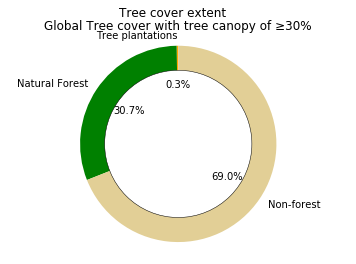

In [6]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
elif adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
elif adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")
else:
    dynamic_sentence = (f"Global Tree cover "
                        f"with tree canopy of \u2265{threshold}%")

if location in ['All Region']: 
    labels = ['Tree plantations', 'Natural Forest', 'Non-forest']
    sizes = [plantations, tree_cover_extent_2010 - plantations, total_area - tree_cover_extent_2010]
    colors = ['orange','green','#E2CF96']
else: 
    labels = ['Tree cover', 'Non-forest']
    sizes = [tree_cover_extent_2010, total_area - tree_cover_extent_2010]
    colors = ['green','grey']
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

In [31]:
print(f"Globally there is {int(tree_cover_extent_2010)}Ha ", end="")
print(f"of forest, covering around ", end="")
print(f"{round(100 * (tree_cover_extent_2010) / total_area, 1)}% of the Earth's land. ", end="")
print(f"Planted forests account for {int(plantations)}Ha of this. ", end="")

Globally there is 3992819698Ha of forest, covering around 31.0% of the Earth's land. Planted forests account for 33980685Ha of this. 

# IFL ver

In [55]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

adm0 = None
adm1 = None
adm2 = None

threshold = 30
location = 'Intact Forest Landscapes'
extent_year = 2000

tags = ["land_cover"]
selectable_polynames = ['ifl_2013', 'ifl_2013__mining','ifl_2013__wdpa']

In [56]:
# Get Intact Forest Landscapes extent and  region area

if location in ['Intact Forest Landscapes',
                'Protected Areas in Intact Forest Landscapes',
                'Mining in Intact Forest Landscapes']:
    sql = global_extent_queries(p_name=polynames['Intact Forest Landscapes'], year=extent_year_dict[extent_year],
                         adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        intact_forest = r.json().get('data')[0].get('value')
    except:
        intact_forest = 0.0
    print(f"\n{adm0} {adm1} {adm2} intact forst area = {intact_forest} ha")
else:
    print(f"No data, for '{intact_forest}'")

    intact_forest = None

Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27ifl_2013%27
Status: 200
{'data': [{'total_area': 3439104228.0238037, 'value': 955345462.6124797}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27ifl_2013%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None intact forst area = 955345462.6124797 ha


In [57]:
# Get specific extent and area values for intersections (mining in intact forest etc)
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

if location in ['Intact Forest Landscapes']:
    poly = polynames['All Region']
elif location in ['Protected Areas in Intact Forest Landscapes']:
    poly = polynames['Protected Areas']
elif location in ['Mining in Intact Forest Landscapes']:
    poly = polynames['Mining']
    
sql = global_extent_queries(p_name=poly, year=extent_year_dict[extent_year], adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 12882338532.03318, 'value': 3992819698.666184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None Gadm28 Tree cover extent = 3992819698.666184 ha
total area = 12882338532.03318 ha


In [58]:
# For some locations we will also need to retrieve an area for plantations
# If user is interested on subregion (i.e mining) then get plantations within that subregion


if location in ['Protected Areas in Intact Forest Landscapes']:
    plantations_poly = polynames['Protected areas in Plantations']
elif location in ['Mining in Intact Forest Landscapes']:
    plantations_poly = polynames['Mining in Plantation Areas']
else:
    plantations_poly = polynames['Plantations']
        
    sql = global_extent_queries(p_name=plantations_poly, year=extent_year_dict[extent_year],
                         adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")


Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 1961812368.0457764, 'value': 33980685.91632184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None plantation area = 33980685.91632184 ha


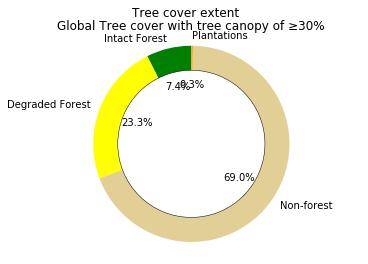

In [59]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

if location in ['Protected Areas in Intact Forest Landscapes', 'Mining in Intact Forest Landscapes']:
        labels = ['Intact Forest', 'Degraded Forest', 'Non-forest']
        sizes = [intact_forest, total_area - intact_forest, total_area - tree_cover_extent_2010]
        colors = ['green', 'yellow','#E2CF96']
        
        labels.append('Plantations')
        sizes.append(plantations)
        colors.append('orange')
        sizes[1] = sizes[1] - plantations

elif location in ['Intact Forest Landscapes']: 
    labels = ['Intact Forest', 'Degraded Forest', 'Non-forest']
    sizes = [intact_forest, tree_cover_extent_2010 - intact_forest, total_area - tree_cover_extent_2010]
    colors = ['green', 'yellow','#E2CF96']
    
    labels.append('Plantations')
    sizes.append(plantations)
    colors.append('orange')
    sizes[1] = sizes[1] - plantations


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

In [46]:
print(f"Globally there is {int(intact_forest)}Ha ", end="")
print(f"of intact forest, which is around ", end="")
print(f"{round(100 * (intact_forest) / tree_cover_extent_2010, 1)}% of the Earth's total tree cover. ", end="")

Globally there is 955345462Ha of intact forest, which is around 23.9% of the Earth's total tree cover. 

# Primary Forest

In [47]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

adm0 = None
adm1 = None
adm2 = None

threshold = 30
location = 'Primary Forests'
year = 2000

tags = ["land_cover"]
selectable_polynames = ['gadm28', 'primary_forest', 'primary_forest__mining', 
                        'primary_forest__wdpa','primary_forest__landmark']

In [48]:
# Get extent and area of region
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

if location in ['Primary Forests']:
    poly = polynames['All Region']
elif location in ['Protected Areas in Primary Forests']:
    poly = polynames['Protected Areas']
elif location in ['Mining in Primary Forests']:
    poly = polynames['Mining']
elif location in ['Indigenous Lands in Primary Forests']:
    poly = polynames['Indigenous Lands']
    
sql = global_extent_queries(p_name=poly, year=extent_year_dict[extent_year],
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 12882338532.03318, 'value': 3992819698.666184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None Gadm28 Tree cover extent = 3992819698.666184 ha
total area = 12882338532.03318 ha


In [49]:
# get primary forests extent and area

if location in ['Primary Forests', 'Mining in Primary Forests',
                'Protected Areas in Primary Forests','Indigenous Lands in Primary Forests']:
    sql = global_extent_queries(p_name=polynames['Primary Forests'], year=extent_year_dict[extent_year],
                         adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        primary_forest = r.json().get('data')[0].get('value')
    except:
        primary_forest = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {primary_forest} ha")
else:
    print(f"No data, for '{primary_forest}'")
    primary_forest = None

Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27primary_forest%27
Status: 200
{'data': [{'total_area': 405952508.91516113, 'value': 201589026.6876325}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27primary_forest%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None plantation area = 201589026.6876325 ha


In [51]:
# Get plantation extent within the region


if location in ['Protected Areas in Primary Forests']:
    plantations_poly = polynames['Protected areas in Plantations']
elif location in ['Indigenous Lands in Primary Forests']:
    plantations_poly = polynames['Indigenous Lands in Plantations']
elif location in ['Mining in Primary Forests']:
    plantations_poly = polynames['Mining in Plantation Areas']
else:
    plantations_poly = polynames['Plantations']

sql = global_extent_queries(p_name=plantations_poly, year=extent_year_dict[extent_year], 
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    plantations = r.json().get('data')[0].get('value')
except:
    plantations = 0.0
print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")


Request for Global area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent_2000%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 1961812368.0457764, 'value': 33980685.91632184}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent_2000%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

None None None plantation area = 33980685.91632184 ha


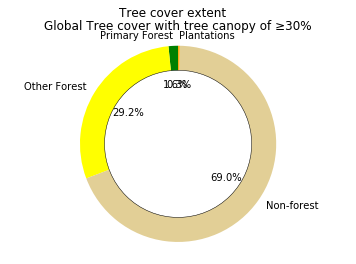

In [53]:
if location in ['Mining in Primary Forests',
                'Protected Areas in Primary Forests','Indigenous Lands in Primary Forests']:
        labels = ['Primary Forest', 'Other Forest', 'Non-forest']
        sizes = [primary_forest, total_area - primary_forest, total_area - super_location]
        colors = ['green', 'yellow','#E2CF96']
        
        labels.append('Plantations')
        sizes.append(plantations)
        colors.append('orange')
        sizes[1] = sizes[1] - plantations

elif location in ['Primary Forests']: 
    labels = ['Primary Forest', 'Other Forest', 'Non-forest']
    sizes = [primary_forest, tree_cover_extent_2010 - primary_forest, total_area - tree_cover_extent_2010]
    colors = ['green', 'yellow','#E2CF96']

    labels.append('Plantations')
    sizes.append(plantations)
    colors.append('orange')
    sizes[1] = sizes[1] - plantations
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

In [60]:
print(f"Globally there is {int(primary_forest)}Ha ", end="")
print(f"of primary forest, which is around ", end="")
print(f"{round(100 * (primary_forest) / tree_cover_extent_2010, 1)}% of the Earth's total tree cover. ", end="")

Globally there is 201589026Ha of primary forest, which is around 5.0% of the Earth's total tree cover. 